In [1]:
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xscen as xs
from pathlib import Path

# Create a project Catalog
project = {"title": "example-diagnostics",
           "description": "This is an example catalog for xscen's documentation."
          }

pcat = xs.ProjectCatalog(f"{Path().absolute()}/samples/example-diagnostics.json", create=True, project=project, overwrite=True)

Successfully wrote ESM catalog json file to: file:///home/rondeau/python/github/xscen/docs/notebooks/samples/example-diagnostics.json


# Diagnostics

It can be useful to perform a various diagnostic tests in order to check that the data that was produced is as expected. Diagnostics can also help us assess bias adjustment methods.

Make sure you run GettingStarted.ipynb before this one, the GettingStarted outputs will be used a inputs in this notebook.

In [2]:
# Load catalog from the GettingStarted notebook
gettingStarted_cat = xs.ProjectCatalog(f"{Path().absolute()}/samples/example-gettingstarted.json")

## Properties and measures

This framework for the diagnostic tests was inspired by the [VALUE project](http://www.value-cost.eu/).
Statistical Properties is the xclim term for 'indices' in the VALUE project.

The `xscen.properties_and_measures` fonction is a wrapper for [xclim.sbda.properties](https://xclim.readthedocs.io/en/stable/sdba.html#properties-submodule) and [xclim.sbda.measures](https://xclim.readthedocs.io/en/stable/sdba.html#measures-submodule).

- `xclim.sbda.properties` are statistical properties of a climate dataset. They allow for a better understanding of the climate by collapsing the time dimension. A few examples: mean, variance, mean spell length, annual cycle, etc.

- `xclim.sbda.measures` assess the difference between two datasets of properties. A few examples: bias, ratio, circular bias, etc.

Let's start by calculating the properties on the reference dataset.
You have to provide the path to a YAML file `properties` describing the properties you want to compute.
You can also specify a period to select and a unit conversion to apply before computing the properties.

This example will use a YAML file structured like this:

```
realm: generic
indicators:
  quantile_98_tas:
    base: xclim.sdba.properties.quantile
    cf_attrs:
      long_name: 98th quantile of the mean temperature
    input:
      da: tas
    parameters:
      q: 0.98
      group: time.season
  maximum_length_of_warm_spell:
    base: xclim.sdba.properties.spell_length_distribution
    cf_attrs:
      long_name: Maximum spell length distribution when the mean temperature is larger or equal to the 90th quantile.
    input:
      da: tas
    parameters:
      method: quantile
      op: '>='
      thresh: 0.9
      stat: max
  mean-tas:
    base: xclim.sdba.properties.mean
    cf_attrs:
      long_name: Ratio of the mean temperature
    input:
      da: tas
    measure: xclim.sdba.measures.RATIO
```

In [3]:
properties = 'samples/properties.yml'
period = [2000,2004]
change_units_arg= {'tas':'degC'}

The properties can be given an argument `group` ('time', 'time.season' or 'time.month'). For 'time', the time collapsing will be performed over the whole period. For 'time.season'/'time.month', the time collapsing will be performed over each season/month. See `quantile_98_tas` as an example for season.

In [4]:
#load input
# 'CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp245_r2i1p1f1_example-region' was used as the reference dataset for this example
dref= gettingStarted_cat.search(id='CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp245_r2i1p1f1_example-region', processing_level='regridded').to_dask()

#calculate properties and measures
prop_ref, _ = xs.properties_and_measures(ds=dref,
                                         properties= properties,
                                         period= period,
                                         change_units_arg= change_units_arg,
                                         to_level_prop = 'diag-properties-ref'
                                        )

# save and update catalog
filename = f"samples/{prop_ref.attrs['cat:id']}.{prop_ref.attrs['cat:domain']}.{prop_ref.attrs['cat:processing_level']}.zarr"
xs.save_to_zarr(ds= prop_ref, filename =filename, mode ='o' )
pcat.update_from_ds(ds = prop_ref, path =filename)
prop_ref

2022-11-18 15:47:44,567 - xscen.diagnostics - INFO - 1 - Computing quantile_98_tas.
2022-11-18 15:47:44,621 - xscen.diagnostics - INFO - 2 - Computing maximum_length_of_warm_spell.
2022-11-18 15:47:44,686 - xscen.diagnostics - INFO - 3 - Computing mean-tas.


<xarray.Dataset>
Dimensions:                       (lat: 4, lon: 4, season: 4)
Coordinates:
  * lat                           (lat) float64 48.62 48.88 49.12 49.38
  * lon                           (lon) float64 -68.38 -68.12 -67.88 -67.62
  * season                        (season) <U3 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    quantile_98_tas               (season, lat, lon) float64 dask.array<chunksize=(1, 4, 4), meta=np.ndarray>
    maximum_length_of_warm_spell  (lat, lon) float32 dask.array<chunksize=(4, 4), meta=np.ndarray>
    mean-tas                      (lat, lon) float32 dask.array<chunksize=(4, 4), meta=np.ndarray>
Attributes: (12/59)
    Conventions:               CF-1.7 CMIP-6.2
    branch_time:               0.0
    branch_time_in_child:      0.0
    cat:_data_format_:         zarr
    cat:activity:              ScenarioMIP
    cat:date_end:              2025-12-31 00:00
    ...                        ...
    sub_experiment_id:         none
    table_id:                  day
    table_info:                Creation Date:(24 July 2019) MD5:0bb394a356ef9...
    title:                     NorESM2-MM output prepared for CMIP6
    variable_id:               tas
    variant_label:             r2i1p1f1

To compute a measure as well as a property, add the `dref_for_measure` argument with the reference properties calculated above. This will mesure the difference between the reference properties and the scenario properties.
A default measure is associated with each properties, but it is possible to define a new one in the YAML (see `mean-tas` for example where the default (bias) was changed for ratio.)

In [5]:
#load input
dscen= gettingStarted_cat.search(source='NorESM2-MM', experiment='ssp245', member="r1.*", processing_level='biasadjusted').to_dask()

#calculate properties and measures
prop_scen, meas_scen = xs.properties_and_measures(ds=dscen,
                                      properties= properties,
                                      period= period,
                                      dref_for_measure = prop_ref,
                                      change_units_arg= {'tas':'degC'},
                                      to_level_prop = 'diag-properties-scen',
                                      to_level_meas = 'diag-measures-scen',
                                     )


display(prop_scen)
display(meas_scen)

# save and update catalog
for ds in [prop_scen, meas_scen]:
    filename = f"samples/{ds.attrs['cat:id']}.{ds.attrs['cat:domain']}.{ds.attrs['cat:processing_level']}.zarr"
    xs.save_to_zarr(ds= ds, filename =filename , mode ='o')
    pcat.update_from_ds(ds = ds, path =filename)

2022-11-18 15:48:19,664 - xscen.diagnostics - INFO - 1 - Computing quantile_98_tas.
2022-11-18 15:48:19,722 - xscen.diagnostics - INFO - 2 - Computing maximum_length_of_warm_spell.
2022-11-18 15:48:19,790 - xscen.diagnostics - INFO - 3 - Computing mean-tas.


<xarray.Dataset>
Dimensions:                       (lat: 4, lon: 4, season: 4)
Coordinates:
  * lat                           (lat) float64 48.62 48.88 49.12 49.38
  * lon                           (lon) float64 -68.38 -68.12 -67.88 -67.62
  * season                        (season) <U3 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    quantile_98_tas               (lon, season, lat) float64 dask.array<chunksize=(4, 1, 4), meta=np.ndarray>
    maximum_length_of_warm_spell  (lat, lon) float32 dask.array<chunksize=(4, 4), meta=np.ndarray>
    mean-tas                      (lon, lat) float32 dask.array<chunksize=(4, 4), meta=np.ndarray>
Attributes: (12/63)
    Conventions:                  CF-1.7 CMIP-6.2
    branch_time:                  0.0
    branch_time_in_child:         0.0
    cat:_data_format_:            zarr
    cat:activity:                 ScenarioMIP
    cat:bias_adjust_institution:  Ouranos
    ...                           ...
    table_id:                     day
    table_info:                   Creation Date:(24 July 2019) MD5:0bb394a356...
    title:                        NorESM2-MM output prepared for CMIP6
    variable_id:                  tas
    variant_label:                r1i1p1f1
    version_id:                   v20191108

<xarray.Dataset>
Dimensions:                       (lat: 4, lon: 4, season: 4)
Coordinates:
  * lat                           (lat) float64 48.62 48.88 49.12 49.38
  * lon                           (lon) float64 -68.38 -68.12 -67.88 -67.62
  * season                        (season) <U3 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    quantile_98_tas               (lon, season, lat) float64 dask.array<chunksize=(4, 1, 4), meta=np.ndarray>
    maximum_length_of_warm_spell  (lat, lon) float32 dask.array<chunksize=(4, 4), meta=np.ndarray>
    mean-tas                      (lon, lat) float32 dask.array<chunksize=(4, 4), meta=np.ndarray>
Attributes: (12/63)
    Conventions:                  CF-1.7 CMIP-6.2
    branch_time:                  0.0
    branch_time_in_child:         0.0
    cat:_data_format_:            zarr
    cat:activity:                 ScenarioMIP
    cat:bias_adjust_institution:  Ouranos
    ...                           ...
    table_id:                     day
    table_info:                   Creation Date:(24 July 2019) MD5:0bb394a356...
    title:                        NorESM2-MM output prepared for CMIP6
    variable_id:                  tas
    variant_label:                r1i1p1f1
    version_id:                   v20191108

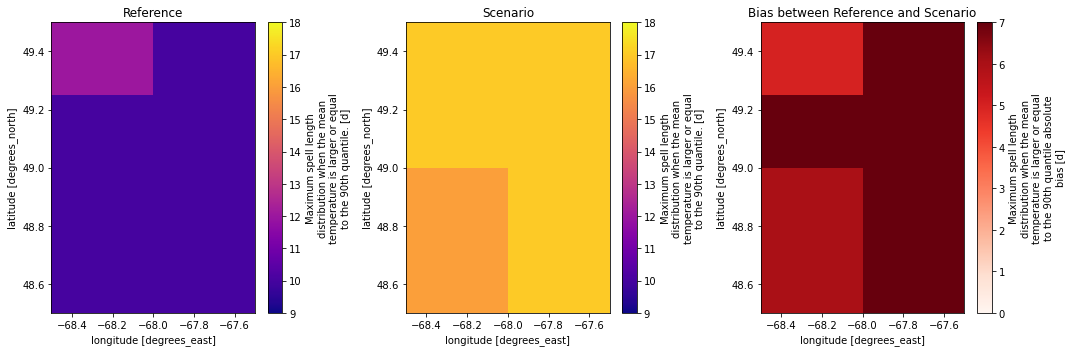

In [8]:
var = 'maximum_length_of_warm_spell'

#plot
fig, axs = plt.subplots(1,3, figsize=(15,5))
prop_ref[var].transpose("lat", ...).plot(ax=axs[0],cmap ='plasma', vmin=9, vmax=18)
prop_scen[var].transpose("lat", ...).plot(ax=axs[1], cmap ='plasma', vmin=9, vmax=18)
meas_scen[var].transpose("lat", ...).plot(ax=axs[2], cmap ='Reds', vmin=0, vmax=7)
axs[0].set_title('Reference')
axs[1].set_title('Scenario')
axs[2].set_title('Bias between Reference and Scenario')
fig.tight_layout()

If you have different methods of bias adjustement, you might want to compare them and see for each property which method performs best (bias close to 0, ratio close to 1) with a `measures_heatmap`.

Below is an example comparing properties of a simulation (no bias adjustment) and a scenario (with quantile mapping bias adjustment). Both the simulation and the scenario use the same reference for the measures. 

Note that it is possible to add many rows to `measures_heatmap`.

<div class="alert alert-info"> <b>NOTE:</b> The bias correction performed in the Getting Started tutorial was adjusted for speed rather than performance, using only a few quantiles. The performance results below are thus quite poor, but that was expected.</div>

In [9]:
# repeat the step above for the simulation (no bias adjustment)
dsim= gettingStarted_cat.search(source='NorESM2-MM', experiment='ssp245', member="r1.*", processing_level='regridded').to_dask()
prop_sim, meas_sim = xs.properties_and_measures(ds=dsim,
                                                properties= properties,
                                                period= period,
                                                dref_for_measure = prop_ref,
                                                change_units_arg= change_units_arg,
                                                to_level_prop = 'diag-properties-sim',
                                                to_level_meas = 'diag-measures-sim',)

# save and update catalog
for ds in [prop_sim, meas_sim]:
    filename = f"samples/{ds.attrs['cat:id']}.{ds.attrs['cat:domain']}.{ds.attrs['cat:processing_level']}.zarr"
    xs.save_to_zarr(ds= ds, filename =filename, mode ='o' )
    pcat.update_from_ds(ds = ds, path =filename)

2022-11-18 15:49:56,970 - xscen.diagnostics - INFO - 1 - Computing quantile_98_tas.
2022-11-18 15:49:57,026 - xscen.diagnostics - INFO - 2 - Computing maximum_length_of_warm_spell.
2022-11-18 15:49:57,091 - xscen.diagnostics - INFO - 3 - Computing mean-tas.


In [10]:
# load the measures for both kinds of data (sim and scen)
meas_datasets= pcat.search(processing_level =[ 'diag-measures-sim','diag-measures-scen']).to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/tmp/ipykernel_87390/3598019772.py:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.


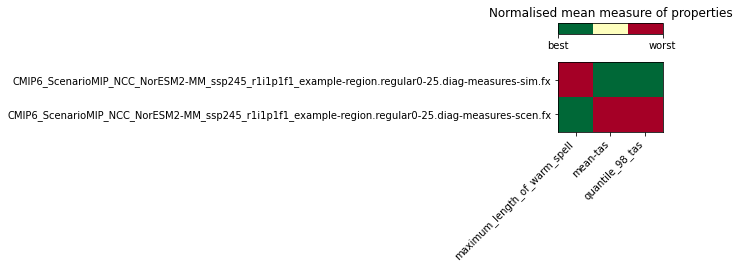

In [11]:
from matplotlib import colors

#calculate the heatmap
hm = xs.diagnostics.measures_heatmap(meas_datasets= meas_datasets)

#plot the heat map
fig_hmap, ax = plt.subplots(figsize=(10,2))
cmap=plt.cm.RdYlGn_r
norm = colors.BoundaryNorm(np.linspace(0,1,4), cmap.N)
im = ax.imshow(hm.heatmap.values, cmap=cmap, norm=norm)
ax.set_xticks(ticks = np.arange(3), labels=hm.properties.values, rotation=45,ha='right')
ax.set_yticks(ticks = np.arange(2), labels=hm.datasets.values)
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='15%', pad=0.4)
fig_hmap.add_axes(cax)
cbar = fig_hmap.colorbar(im, cax=cax, ticks=[0, 1], orientation='horizontal')
cbar.ax.set_xticklabels(['best', 'worst'])
plt.title('Normalised mean measure of properties')
fig_hmap.tight_layout()

`measure_improved` is another way to compare two datasets. It returns the fraction of the grid points that performed better in the second dataset than in the first dataset. It is useful to see which of properties are best corrected for by the bias adjustement method.

/tmp/ipykernel_87390/1437910549.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.


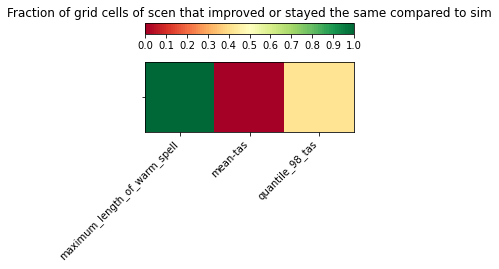

In [12]:
# change the order of meas_dataset to have sim first, because we want to see how scen improved compared to sim.
ordered_keys=['CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp245_r1i1p1f1_example-region.regular0-25.diag-measures-sim.fx',
             'CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp245_r1i1p1f1_example-region.regular0-25.diag-measures-scen.fx']
meas_datasets ={k:meas_datasets[k] for k in ordered_keys }

pb = xs.diagnostics.measures_improvement(meas_datasets= meas_datasets)

#plot
percent_better= pb.improved_grid_points.values
percent_better=np.reshape(np.array(percent_better), (1, 3))
fig_per, ax = plt.subplots(figsize=(10, 2))
cmap=plt.cm.RdYlGn
norm = colors.BoundaryNorm(np.linspace(0,1,100), cmap.N)
im = ax.imshow(percent_better, cmap=cmap, norm=norm)
ax.set_xticks(ticks=np.arange(3), labels= pb.properties.values, rotation=45,ha='right')
ax.set_yticks(ticks=np.arange(1), labels=[''])

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='15%', pad=0.4)
fig_per.add_axes(cax)
cbar = fig_per.colorbar(im, cax=cax, ticks=np.arange(0,1.1,0.1), orientation='horizontal')
plt.title('Fraction of grid cells of scen that improved or stayed the same compared to sim')
fig_per.tight_layout()